# Fake maps with fake seeing

+ Generate simulated emissivity and velocity cubes
+ Integrate them to get simulated intensity, velocity (and sigma) maps
+ Calculate structure functions and other statistics (PDFs, delta variance, etc)
+ Apply fake seeing to the cubes and investigate the effect on the structure function, etc
+ Also see if there is any difference if we just simulate a velocity map and apply seeing to that

In [1]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
import astropy.units as u
from matplotlib import pyplot as plt
import turbustat.statistics as tss
import turbustat.simulator
from turbustat.simulator import make_3dfield, make_extended
import seaborn as sns
import sys
sys.path.append("../muse-strucfunc")
import strucfunc

sns.set_color_codes()
sns.set_context("talk")

## Fake velocity maps only

In [30]:
vmap = make_extended(
    256, powerlaw=4.0, 
    ellip=0.5, theta=45, 
    randomseed=2021_10_07,
)
vmap /= vmap.std()

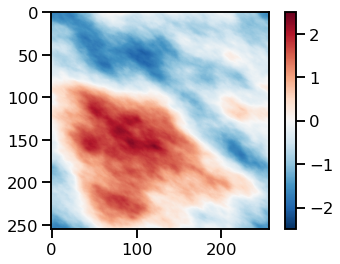

In [31]:
fig, ax = plt.subplots()
im = ax.imshow(vmap, vmin=-2.5, vmax=2.5, cmap="RdBu_r")
fig.colorbar(im, ax=ax)

### Structure function of fake velocity map

In [32]:
sf = strucfunc.strucfunc_numba_parallel(vmap, dlogr=0.05)

/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [33]:
sf

{'log10 r': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 ]),
 'Sum dv^2': array([9.29597820e+01, 0.00000000e+00, 0.00000000e+00, 4.69989458e+02,
        0.00000000e+00, 0.00000000e+00, 2.47258425e+03, 0.00000000e+00,
        0.00000000e+00, 2.29034471e+03, 3.93626855e+03, 4.90050721e+03,
        1.05838681e+04, 1.72924430e+04, 1.86785057e+04, 3.05917352e+04,
        6.55855785e+04, 6.69092201e+04, 1.13391057e+05, 1.85101889e+05,
        3.35468453e+05, 4.14188572e+05, 6.26743858e+05, 1.06336044e+06,
        1.42893403e+06, 2.21169520e+06, 3.42489342e+06, 4.95210665e+06,
        7.14121374e+06, 1.02864029e+07, 1.56674580e+07, 2.11336795e+07,
        3.16731515e+07, 4.35377949e+07, 6.10747287e+0

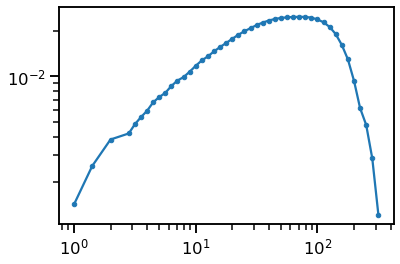

In [35]:
fig, ax = plt.subplots()
m = sf["N pairs"] > 0
r = 10**sf["log10 r"][m]
B = sf["Unweighted B(r)"][m]
ax.plot(
    r, 
    B / r, 
    marker=".",
)
ax.set(xscale="log", yscale="log");

### Smoothed version of velocity field



In [36]:
from astropy.convolution import Gaussian2DKernel, convolve_fft

In [37]:
widths = [1, 2, 4, 8, 16, 32]
vmaps = {}
for width in widths:
    kernel = Gaussian2DKernel(x_stddev=width)
    vmaps[width] = convolve_fft(vmap, kernel)

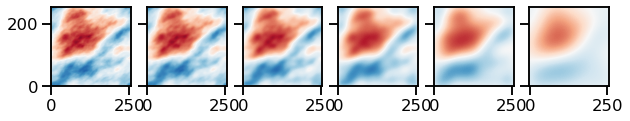

In [38]:
ncols = len(widths)
fig, axgrid = plt.subplots(
    1, ncols, figsize=(10, 5), sharex=True, sharey=True,
)
for ax, width in zip(axgrid, widths):
    im = ax.imshow(
        vmaps[width], 
        origin="lower",
        vmin=-2.5, vmax=2.5,
        cmap="RdBu_r",
    )

In [39]:
sfs = {}
for width in widths:
    sfs[width] = strucfunc.strucfunc_numba_parallel(
        vmaps[width], dlogr=0.05,
    )

/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


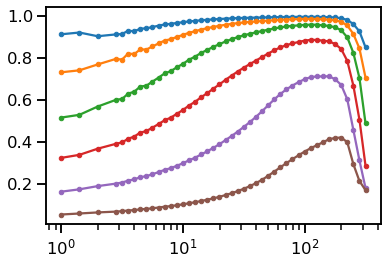

In [43]:
fig, ax = plt.subplots()
m = sf["N pairs"] > 0
B0 = sf["Unweighted B(r)"][m]
for width in widths:
    r = 10**sfs[width]["log10 r"][m]
    B = sfs[width]["Unweighted B(r)"][m]
    ax.plot(
        r, 
        B / B0, 
        marker=".",
    )
ax.set(xscale="log", yscale="linear");

## Fake emissivity and velocity cubes